In [1]:
import sys
import os
# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())
# os.environ["JULIA_NUM_THREADS"] = "8" 
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"
os.environ["PYTHON_JULIACALL_THREADS"] = "auto"
os.environ["PYTHON_JULIACALL_OPTLEVEL"] = "3"
from pysr import PySRRegressor
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [62]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/credit_score/cleaned_credit_score_v2.csv")
# remove columns that are not categorical or numerical
data = data.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Payment_Behaviour'], axis=1)

In [3]:
# Generate the profiling report
profile_full = ProfileReport(data, title="Credit Score Cleaned", explorative=True)

# Get the description object
desc_full = profile_full.get_description()

# Access the correlation matrix
correlation_matrix = desc_full.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
categorical_cols = get_categorical_columns(data)
distributions = fit_distributions(data)
marginals = convert_distfit_to_marginals(distributions, data)

In [5]:
data_syn = generate_synthetic_dataset(original_data=data, correlation_matrix=correlation_matrix, categorical_columns=categorical_cols, marginals=marginals, n_rows=40000, correlation_threshold=0.1, edge_strategy="random", sampling_strategy="local-chunks")

In [6]:
# Generate the profiling report
profile_syn = ProfileReport(data_syn, title="Credit Score Cleaned SYN", explorative=True)

# Get the description object
desc_syn = profile_syn.get_description()

# Access the correlation matrix
correlation_matrix_syn = desc_syn.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn, "Real", "Synthetic")

In [8]:
from sdmetrics.reports.single_table import QualityReport

data_syn = data_syn[data.columns.to_list()]

metadata = {
    "columns": {
        "Month": {"sdtype": "categorical"},
        "Age": {"sdtype": "numerical"},
        "Occupation": {"sdtype": "categorical"},
        "Annual_Income": {"sdtype": "numerical"},
        "Monthly_Inhand_Salary": {"sdtype": "numerical"},
        "Num_Bank_Accounts": {"sdtype": "numerical"},
        "Num_Credit_Card": {"sdtype": "numerical"},
        "Interest_Rate": {"sdtype": "numerical"},
        "Num_of_Loan": {"sdtype": "numerical"},
        "Delay_from_due_date": {"sdtype": "numerical"},
        "Num_of_Delayed_Payment": {"sdtype": "numerical"},
        "Changed_Credit_Limit": {"sdtype": "numerical"},
        "Num_Credit_Inquiries": {"sdtype": "numerical"},
        "Credit_Mix": {"sdtype": "categorical"},
        "Outstanding_Debt": {"sdtype": "numerical"},
        "Credit_Utilization_Ratio": {"sdtype": "numerical"},
        "Credit_History_Age": {"sdtype": "numerical"},
        "Payment_of_Min_Amount": {"sdtype": "categorical"},
        "Total_EMI_per_month": {"sdtype": "numerical"},
        "Amount_invested_monthly": {"sdtype": "numerical"},
        "Monthly_Balance": {"sdtype": "numerical"},
    }
}

report = QualityReport()
report.generate(data, data_syn, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 21/21 [00:00<00:00, 39.20it/s]|
Column Shapes Score: 93.73%

(2/2) Evaluating Column Pair Trends: |██████████| 210/210 [00:01<00:00, 121.01it/s]|
Column Pair Trends Score: 91.75%

Overall Score (Average): 92.74%



In [9]:
data_sample = data_syn.sample(n=9600, random_state=42)
# variable assignment according to correlation structure
independents_lst = ['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts', 'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']
dependent_var = 'Interest_Rate'
X = data_sample[independents_lst].to_numpy()
y = data_sample[dependent_var].to_numpy()
data_sample = data_sample.reset_index()

10.4**2 * RBF(length_scale=30) + WhiteKernel(noise_level=20)


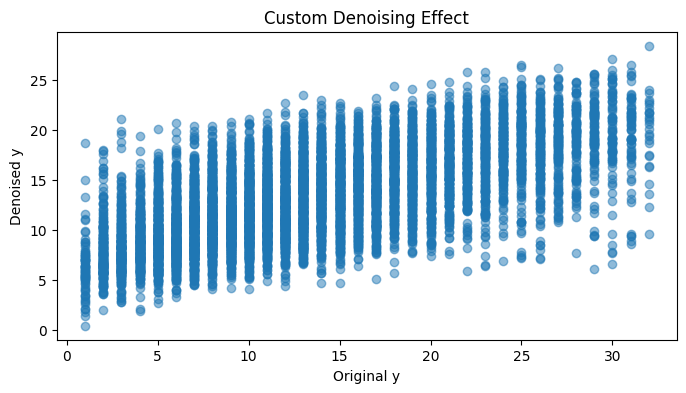

In [10]:
%matplotlib inline
y_denoised = bound_denoise(X, y, length_scale_bounds=(1e-3, 30), noise_level_bounds=(1e-5, 20), show_denoising_effect=True)

In [11]:
sr_model = PySRRegressor(
        niterations=1024,  # Number of iterations to search for equations
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log", "abs", "sqrt"],
        elementwise_loss="loss(x, y) = (x - y)^2",  # Define loss function (mean squared error)
        verbosity=0,
        maxsize=50
    )
sr_model.fit(X, y_denoised)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           13.31878   
	1         0.249935                                     x2 + 7.9156113   
	2         0.191964                                       log(x5) + x2   
	3         0.030681                       sqrt(sqrt(x5 / 0.033057094))   
	4         0.172013                        x2 + sqrt(x5 * 0.048730463)   
	5         0.105419                    x2 + sqrt(sqrt(x5 * 3.9036016))   
	6         0.171233                     sqrt(x3) + sqrt(sqrt(x4 * x5))   
	7         0.161345                    sqrt(sqrt(x3 * x5) + (x2 * x4))   
	8         0.026765              sqrt((x1 + sqrt(x5)) * sqrt(x2 + x3))   
	9         0.084352      sqrt((x4 * x2) + sqrt((x5 * 1.4505166) * x3))   
	10  >>>>  0.090757        sqrt(abs(x1) + ((x4 * x2) + sqrt(x5 * x3)))   
	11        0.003003      sqrt(x1 + (sqrt((x5 * x3) + x0) + (x4 * x2)))   
	12        0.009537  sqrt(sqrt(x3 + x2) * (((sqrt(x5) + x1) * 0.712...   
	13        0.001062  sqrt((x4 + ((sqrt(x5) + abs(x1)) * 0.71208346)...   
	14        0.051030  sqrt(x1 + (sqrt(x2 + x3) * (sqrt(x5 + 1293.487...   
	15        0.042048  sqrt(sqrt(x3 + x2) * (x4 + ((x1 + sqrt(x5)) * ...   
	16        0.002104  sqrt(sqrt(x3 + x2) * (x4 + ((abs(x1) + sqrt(x5...   
	17        0.016933  sqrt(sqrt(x3 + x2) * ((((sqrt(x5) + x1) + x2) ...   
	18        0.001204  abs(sqrt(sqrt(x3 + x2) * (((sqrt(x5) + (x1 + x...   
	19        0.001607  sqrt(sqrt(x3 + x2) * (x4 + (((x1 + sqrt(x5)) +...   
	20        0.001708  abs((cos(sqrt(x0)) + 0.3644617) - sqrt(sqrt(x2...   
	21        0.007725  (sqrt(((x4 + ((sqrt(x5) + x1) * 0.62552816)) +...   
	22        0.000062  sqrt(sqrt((x3 - -1.3616824) + x2) * ((((sqrt(x...   
	23        0.002974  sqrt((((sqrt(x5) + x1) * 0.6188763) + (x4 + x2...   
	24        0.001292  sqrt(sqrt((x3 - -1.3616824) + x2) * (((sqrt(x5...   
	25        0.006151  20.956789 - abs(((x0 * -0.1211184) + -21.38567...   
	26        0.004758  abs(20.965075 - abs(((x0 * -0.1228632) + (sqrt...   
	27        0.008281  20.959562 - abs(((x0 * -0.12415693) + -21.5366...   
	28        0.017692  abs(abs((sqrt(sqrt(x4 + (x2 + x2))) * sqrt(sqr...   
	29        0.002626  abs(abs(abs((x0 * -0.12896174) + (sqrt(sqrt(x4...   
	30        0.001149  abs(16.625553 - abs((sqrt(sqrt(x4 + (x2 + (x2 ...   
	31        0.009487  abs(abs(17.22589 - abs((x0 * -0.13193788) + ((...   
	32        0.001682  abs(abs(17.241255 - abs(abs((x0 * -0.13211302)...   
	33        0.002105  abs((abs(16.716959 - abs((sqrt(sqrt(x2 + (x4 +...   
	34        0.002295  abs((abs(16.609303 - abs(abs((x0 * -0.11867552...   
	35        0.003441  abs((abs(16.369081 - abs(((x0 * -0.116303764) ...   
	36        0.000244  abs((abs(abs(((sqrt(sqrt(x4 + ((x2 + x2) - -1....   
	37        0.005561  abs(abs((sqrt(sqrt(((x1 - -9.208993) * sqrt(x3...   
	38        0.001124  abs(abs(((x0 * -0.111477144) + -18.279776) + (...   
	39        0.013887  abs(abs(((sqrt(sqrt(x5 + ((x1 - -10.625892) * ...   
	40        0.000616  abs(abs(((sqrt(sqrt(((abs(x1) - -10.6204) * sq...   
	41        0.006523  abs(abs((x0 * -0.114840105) + ((sqrt(sqrt(x5 +...   
	42        0.000709  abs(sqrt(sqrt(sqrt(x3 * (x5 * (x2 + x4))))) + ...   
	43        0.002160  abs(abs((sqrt(sqrt(x2 + ((x4 * -0.67827636) + ...   
	44        0.000701  abs((sqrt(sqrt(sqrt((x3 * (x4 + 0.75468683)) *...   
	45        0.000207  abs((sqrt(sqrt(sqrt(((x4 + 0.7111694) * x5) * ...   
	
	         loss  complexity  
	0   19.733515           1  
	1   11.970535           3  
	2    9.879716           4  
	3    9.581198           5  
	4    8.067062           6  
	5    7.259931           7  
	6    6.117401           8  
	7    5.205898           9  
	8    5.068411          10  
	9    4.658415          11  
	10   4.254249          12  
	11   4.241492          13  
	12   4.201232          14  
	13   4.196773          15  
	14   3.987985          16  
	15   3.666329          18 

In [12]:
# 20250423_202336_qTuNtG
# Complexity 18
candidate_function = generate_candidate_function("sqrt(sqrt(x3 + x2) * (x4 + ((x1 + sqrt(x5)) * 0.6689411))) - cos(sqrt(x0))")

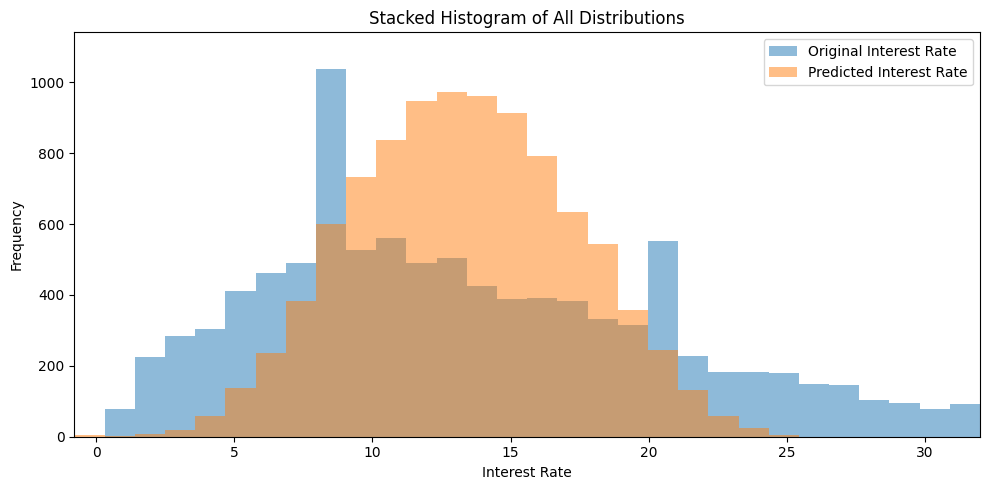

In [14]:
%matplotlib inline
y_pred = candidate_function(X)
plot_histograms([(y, 'Original Interest Rate', None), (y_pred, 'Predicted Interest Rate', None)], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

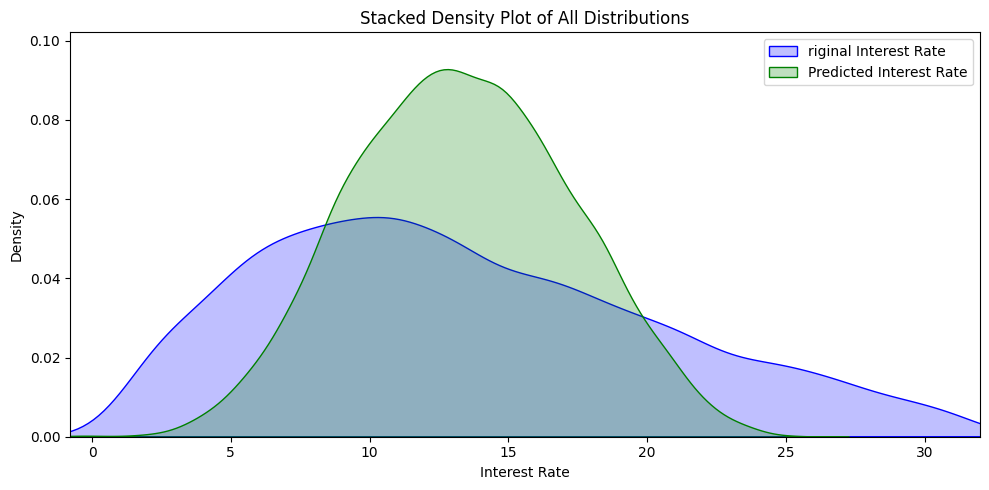

In [15]:
plot_densities([(y, 'riginal Interest Rate', 'blue'), (y_pred, 'Predicted Interest Rate', 'green')], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))

In [16]:
X_total = data_syn[['Credit_History_Age', 'Delay_from_due_date', 'Num_Bank_Accounts', 'Num_Credit_Inquiries', 'Num_of_Delayed_Payment', 'Outstanding_Debt']].to_numpy()
y_total = data_syn['Interest_Rate'].to_numpy()

In [17]:
y_pred_total = candidate_function(X_total)

In [18]:
orig_residuals = y_total - y_pred_total

In [19]:
y_pred_total_corrected, best_amp, errors, _ = renoise_predictions(y_total, y_pred_total, method='stratified', seed=42, clip_lower=0, clip_upper=32, original_residuals=None, tail_replace=True, lower_percentile=50, upper_percentile=25)
# ignore error in orig_residuals after first run

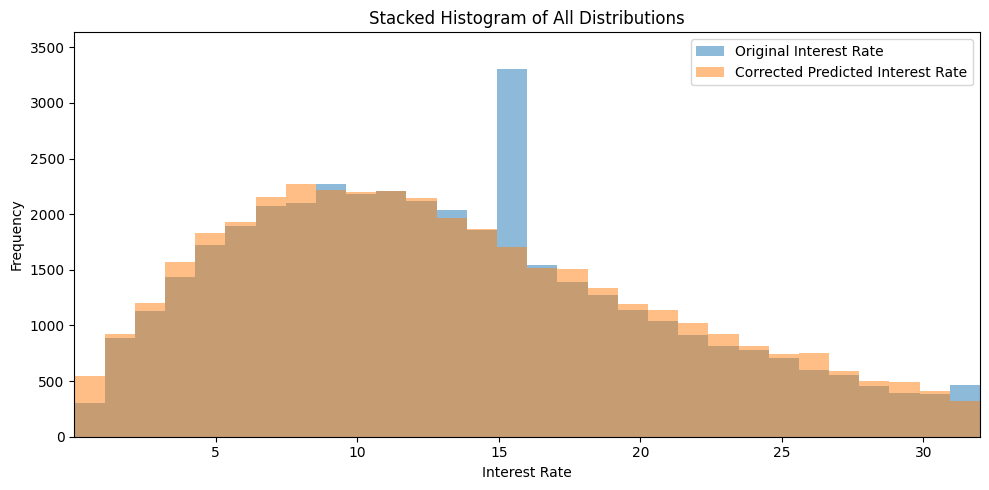

In [21]:
plot_histograms([(y_total, 'Original Interest Rate', None), (y_pred_total_corrected, 'Corrected Predicted Interest Rate', None)], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

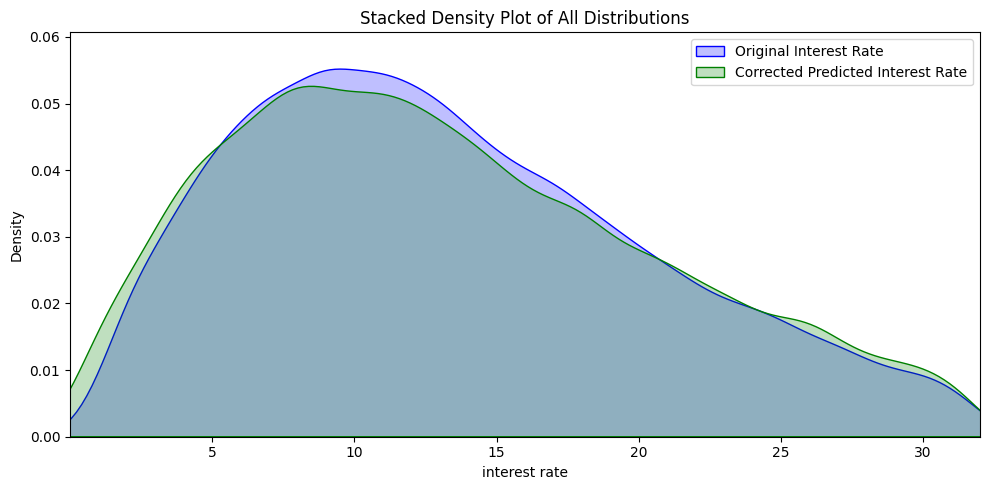

In [22]:
plot_densities([(y_total, 'Original Interest Rate', 'blue'), (y_pred_total_corrected, 'Corrected Predicted Interest Rate', 'green')], 'interest rate', stack=True, figsize_per_plot=(10, 5))

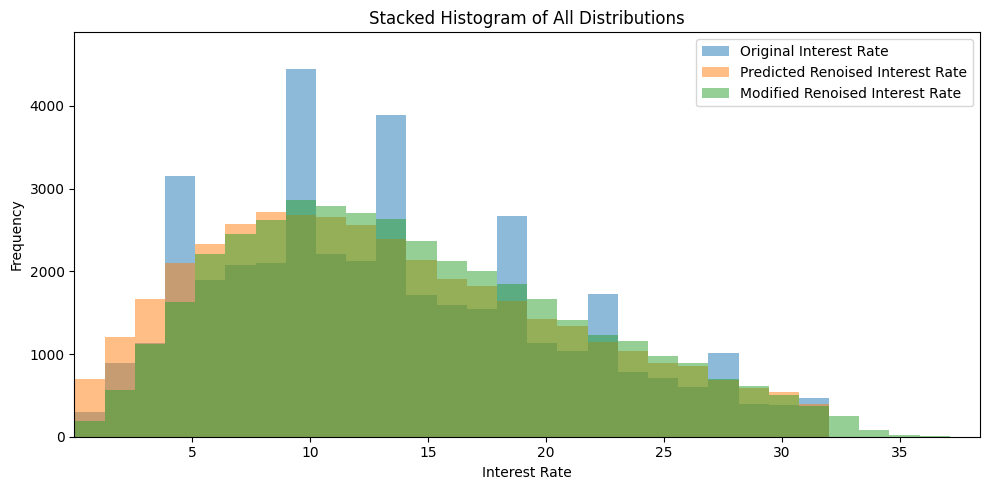

In [29]:
mod_candidate_function = generate_candidate_function("sqrt(sqrt(x3 + 1.7*x2) * (x4 + ((x1 + sqrt(x5)) * 0.6689411))) - cos(sqrt(x0))")
mod_y_pred_total = mod_candidate_function(X_total)
mod_y_pred_total_corrected, best_amp, errors, _ = renoise_predictions(y_total, mod_y_pred_total, method='stratified', amplification_factor=1.0, seed=42, clip_lower=0, clip_upper=None, original_residuals=orig_residuals, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run
plot_histograms([(y_total, 'Original Interest Rate', None), (y_pred_total_corrected, 'Predicted Renoised Interest Rate', None), (mod_y_pred_total_corrected, 'Modified Renoised Interest Rate', None)], 'Interest Rate', stack=True, figsize_per_plot=(10, 5))